In [1]:
import numpy as np
from IPython.display import HTML
from video import Video as Video
# import required packages
import motmetrics as mm
import numpy as np
import sys
import glob
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

%load_ext autoreload

In [11]:
%autoreload 2

root_video_path = '../datasets/AITrack/train/S01/c005/'
video = Video(root_video_path+'vdo.avi')

predictions = video.parse_detection_txt(root_video_path+'mtsc/mtsc_deepsort_mask_rcnn.txt', roi_path=root_video_path+'roi.jpg', remove_parked_cars=True)
groundtruth = video.parse_detection_txt(root_video_path+'gt/gt.txt', remove_parked_cars=False)
# groundtruth = video.parse_detection_txt('output_annotations.txt')
# predictions = video.parse_detection_txt(root_video_path+'det/det_yolo3.txt')

video.parse_video(min_frame=0, end_frame=80, create_video_annot=True, groundtruth=groundtruth, annotations=predictions, create_gif=True)
# video.parse_video(min_frame=0, end_frame=630, create_video_annot=True, groundtruth=groundtruth, create_gif=False)

MoviePy - Building file ./outputs/video/_datasets_AITrack_train_S01_c005.gif with imageio.


In [5]:
import xml.etree.ElementTree as ET
def parse_xml(file_path):
    """
    Parses an XML file and extracts bounding box information for each frame and track.

    Args:
        file_path (str): Path to the XML file.

    Returns:
        tuple: A tuple containing two dictionaries, `tracks` and `frames`.
            `tracks` contains information for each track, with the track IDs as keys and the box information
            for each frame as values.
            `frames` contains information for each frame, with the frame numbers as keys and a list of boxes as
            values.
    """
    # Parse the XML file
    tree = ET.parse(file_path)
    root = tree.getroot()

    frames = {}
    
    # Iterate over the tracks and extract their bounding box information
    for track in root.findall(".//track[@label='car']"):
        track_id = track.get('id')
        for box in track.findall(".//box"):
            box_frame = int(box.get('frame'))
            xtl, ytl, xbr, ybr = map(float, [box.get('xtl'), box.get('ytl'), box.get('xbr'), box.get('ybr')])
            outside, occluded, keyframe = map(int, [box.get('outside'), box.get('occluded'), box.get('keyframe')])
            parked = box.find(".//attribute[@name='parked']").text == 'true'

            # Add the box to the list of boxes for this frame
            if box_frame not in frames:
                frames[box_frame] = []

            frames[box_frame].append({
                'xtl': xtl,
                'ytl': ytl,
                'xbr': xbr,
                'ybr': ybr,
                'track_id': track_id,
                'occluded': occluded
            })

    return frames


frames_gt = parse_xml('../datasets/ai_challenge_s03_c010-full_annotation.xml')
frames_gt = dict(sorted(frames_gt.items(), key=lambda x: x[0]))
# Open the output file for writing
output_file = "output_annotations.txt"
output_fp = open(output_file, "w")

for frame in frames_gt:
    for bbox in frames_gt[frame]:
        x, y, z = -1, -1, -1  # No information about x, y, z
        line = "{},{},{},{},{},{},{},{},{},{}\n".format(
            str(int(frame)+1),
            bbox['track_id'],
            bbox['xtl'],
            bbox['ytl'],
            bbox['xbr'] - bbox['xtl'],
            bbox['ybr'] - bbox['ytl'],
            1,
            x,
            y,
            z
        )

        output_fp.write(line)

#Release the output file
output_fp.close()


In [6]:
def motMetricsEnhancedCalculator(gtSource, tSource, verbose=False):
    # load ground truth
    gt = np.loadtxt(gtSource, delimiter=',')

    # load tracking output
    t = np.loadtxt(tSource, delimiter=',')
    
    if t.shape[0] == 0:
        print('No tracking predictions found')
        return 0

    # Create an accumulator that will be updated during each frame
    acc = mm.MOTAccumulator(auto_id=True)

    # Max frame number maybe different for gt and t files
    for frame in range(int(gt[:,0].max())):
        frame += 1 # detection and frame numbers begin at 1

        # select id, x, y, width, height for current frame
        # required format for distance calculation is X, Y, Width, Height \
        # We already have this format
        gt_dets = gt[gt[:,0]==frame,1:6] # select all detections in gt
        t_dets = t[t[:,0]==frame,1:6] # select all detections in t

        C = mm.distances.iou_matrix(gt_dets[:,1:], t_dets[:,1:], \
                                    max_iou=0.5) # format: gt, t

        # Call update once for per frame.
        # format: gt object ids, t object ids, distance
        acc.update(gt_dets[:,0].astype('int').tolist(), \
                    t_dets[:,0].astype('int').tolist(), C)

    mh = mm.metrics.create()

    summary = mh.compute(acc, metrics=['num_frames', 'idf1', 'idp', 'idr', \
                                        'recall', 'precision', 'num_objects', \
                                        'mostly_tracked', 'partially_tracked', \
                                        'mostly_lost', 'num_false_positives', \
                                        'num_misses', 'num_switches', \
                                        'num_fragmentations', 'mota', 'motp' \
                                    ], \
                        name='acc')

    strsummary = mm.io.render_summary(
        summary,
        #formatters={'mota' : '{:.2%}'.format},
        namemap={'idf1': 'IDF1', 'idp': 'IDP', 'idr': 'IDR', 'recall': 'Rcll', \
                'precision': 'Prcn', 'num_objects': 'GT', \
                'mostly_tracked' : 'MT', 'partially_tracked': 'PT', \
                'mostly_lost' : 'ML', 'num_false_positives': 'FP', \
                'num_misses': 'FN', 'num_switches' : 'IDsw', \
                'num_fragmentations' : 'FM', 'mota': 'MOTA', 'motp' : 'MOTP',  \
                }
    )
    
    if verbose:
        print(strsummary)
    
    return np.round(summary['idf1'].values[0], 4) * 100

Checking the groundtruth

In [7]:
def save_detection_txt(detection_dict, output_file):
    # Open the output file for writing
    output_fp = open(output_file, "w")

    for frame in detection_dict:
        for bbox in detection_dict[frame]:
            x, y, z = -1, -1, -1  # No information about x, y, z
            line = "{},{},{},{},{},{},{},{},{},{}\n".format(
                str(int(frame)+1),
                bbox['id'],
                bbox['xtl'],
                bbox['ytl'],
                bbox['xbr'] - bbox['xtl'],
                bbox['ybr'] - bbox['ytl'],
                1,
                x,
                y,
                z
            )

            output_fp.write(line)

    #Release the output file
    output_fp.close()

In [255]:
sequence = 'S03'
cam = 'c010'
method = 'tc_ssd512'
root_video_path = f'../datasets/AITrack/train/{sequence}/{cam}/'
# predictions = video.parse_detection_txt(root_video_path+'mtsc/mtsc_'+method+'.txt', roi_path=root_video_path+'roi.jpg', remove_parked_cars=True)

predictions_path = './Faster-RCNN-finetuned-03.txt'

predictions = video.parse_detection_txt('./Faster-RCNN-finetuned-03.txt', roi_path=root_video_path+'roi.jpg', remove_parked_cars=True)

predictions_path = f'./outputs/detections/{sequence}_{cam}_{method}_no_parked.txt'
save_detection_txt(predictions, predictions_path)

idf1 = motMetricsEnhancedCalculator(root_video_path+'gt/gt.txt', predictions_path, verbose=True)

     num_frames      IDF1       IDP       IDR      Rcll      Prcn    GT  MT  PT  ML    FP   FN  IDsw  FM      MOTA      MOTP
acc        1949  0.478801  0.332982  0.851832  0.851832  0.332982  1856   8   6   0  3167  275     0   3 -0.854526  0.309128


Check baseline detections and tracking

With parked and without taking into account regions of interest

In [197]:
tracking_methods = ['deepsort', 'moana', 'tc']
nn_methods = ['mask_rcnn', 'ssd512', 'yolo3']

results = {}
for tracking_method in tracking_methods:
    results[tracking_method] = {}
    for nn_method in nn_methods:
        results[tracking_method][nn_method] = []

cams = []

for sequence_path in glob.glob('../datasets/AITrack/train/*'):
    sequence = os.path.basename(sequence_path)
    for cam_path in glob.glob(sequence_path + '/*'):
        cam = os.path.basename(cam_path)
        cams.append(cam)
        root_video_path = f'../datasets/AITrack/train/{sequence}/{cam}/'
        video = Video(root_video_path+'vdo.avi')       
        
        for tracking_method in tracking_methods:
            for nn_method in nn_methods:                
                method = f'{tracking_method}_{nn_method}'
                
                # print(f'cam: {cam}, method: {method}')
                predictions = video.parse_detection_txt(root_video_path+'mtsc/mtsc_'+method+'.txt', roi_path=root_video_path+'roi.jpg', remove_parked_cars=False)
                predictions_path = f'./outputs/detections/{sequence}_{cam}_{method}_parked.txt'
                save_detection_txt(predictions, predictions_path)
                idf1 = motMetricsEnhancedCalculator(root_video_path+'gt/gt.txt', predictions_path)
                results[tracking_method][nn_method].append(idf1)

No tracking predictions found


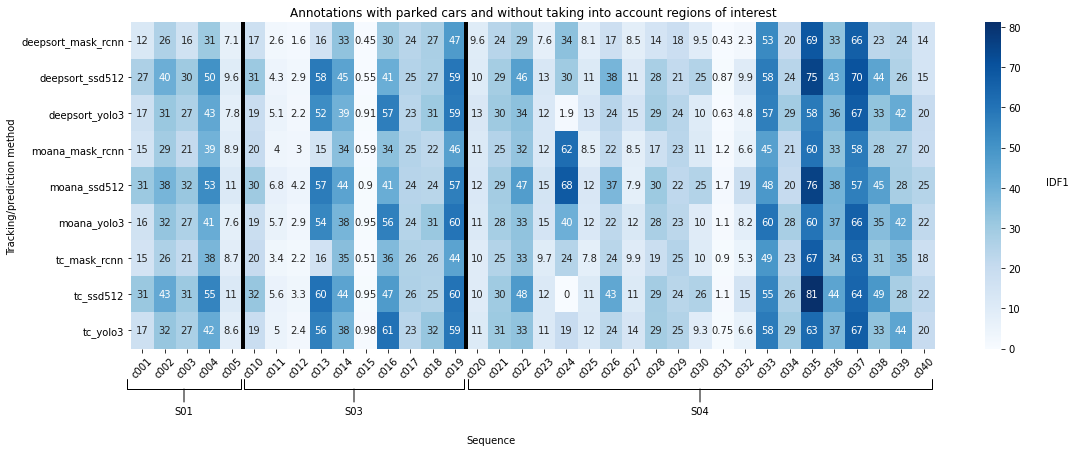

In [223]:
# Create dataframe to show heatmap with cam sequences
results_heatmap = {}
for tracking_method in results.keys():
    for nn_method in results[tracking_method].keys():
        method = f'{tracking_method}_{nn_method}'
        results_heatmap[method] = results[tracking_method][nn_method]
        
df = pd.DataFrame(results_heatmap).T
df.columns = cams

plt.figure(figsize=(18, 6))
ax = sns.heatmap(df, annot=True, cmap='Blues')
plt.title('Annotations with parked cars and without taking into account regions of interest')
plt.ylabel('Tracking/prediction method')
# plt.xlabel('Camera', labelpad=40)
plt.xticks(rotation=45)
ax.vlines([5, 15], *ax.get_xlim(), colors='black', linewidth=4, linestyles='solid')
plt.text(15,11.6,'Sequence',rotation=0)
plt.text(41,4.5,'IDF1',rotation=0)

ax.annotate('S01', xy=(184, 65), xytext=(184, 36), xycoords='figure pixels', 
            fontsize=10, ha='center', va='bottom',
            # bbox=dict(boxstyle='square', fc='white'),
            arrowprops=dict(arrowstyle='-[, widthB=5.7, lengthB=1', lw=1.0))

ax.annotate('S03', xy=(354, 65), xytext=(354, 36), xycoords='figure pixels', 
            fontsize=10, ha='center', va='bottom',
            # bbox=dict(boxstyle='square', fc='white'),
            arrowprops=dict(arrowstyle='-[, widthB=11, lengthB=1', lw=1.0))

ax.annotate('S04', xy=(700, 65), xytext=(700, 36), xycoords='figure pixels', 
            fontsize=10, ha='center', va='bottom',
            # bbox=dict(boxstyle='square', fc='white'),
            arrowprops=dict(arrowstyle='-[, widthB=23.2, lengthB=1', lw=1.0))

pass

Without parked and regions of interest

In [224]:
tracking_methods = ['deepsort', 'moana', 'tc']
nn_methods = ['mask_rcnn', 'ssd512', 'yolo3']

results = {}
for tracking_method in tracking_methods:
    results[tracking_method] = {}
    for nn_method in nn_methods:
        results[tracking_method][nn_method] = []

cams = []

for sequence_path in glob.glob('../datasets/AITrack/train/*'):
    sequence = os.path.basename(sequence_path)
    for cam_path in glob.glob(sequence_path + '/*'):
        cam = os.path.basename(cam_path)
        cams.append(cam)
        root_video_path = f'../datasets/AITrack/train/{sequence}/{cam}/'
        video = Video(root_video_path+'vdo.avi')       
        
        for tracking_method in tracking_methods:
            for nn_method in nn_methods:                
                method = f'{tracking_method}_{nn_method}'
                
                # print(f'cam: {cam}, method: {method}')
                predictions = video.parse_detection_txt(root_video_path+'mtsc/mtsc_'+method+'.txt', roi_path=root_video_path+'roi.jpg', remove_parked_cars=True)
                predictions_path = f'./outputs/detections/{sequence}_{cam}_{method}_no_parked.txt'
                save_detection_txt(predictions, predictions_path)
                idf1 = motMetricsEnhancedCalculator(root_video_path+'gt/gt.txt', predictions_path)
                results[tracking_method][nn_method].append(idf1)

No tracking predictions found


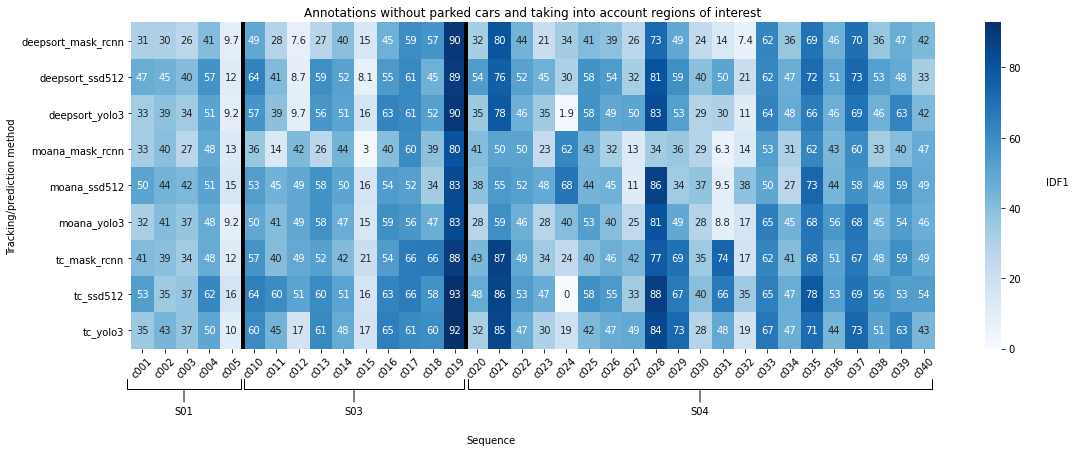

In [225]:
# Create dataframe to show heatmap with cam sequences
results_heatmap = {}
for tracking_method in results.keys():
    for nn_method in results[tracking_method].keys():
        method = f'{tracking_method}_{nn_method}'
        results_heatmap[method] = results[tracking_method][nn_method]
        
df = pd.DataFrame(results_heatmap).T
df.columns = cams

plt.figure(figsize=(18, 6))
ax = sns.heatmap(df, annot=True, cmap='Blues')
plt.title('Annotations without parked cars and taking into account regions of interest')
plt.ylabel('Tracking/prediction method')
# plt.xlabel('Camera', labelpad=40)
plt.xticks(rotation=45)
ax.vlines([5, 15], *ax.get_xlim(), colors='black', linewidth=4, linestyles='solid')
plt.text(15,11.6,'Sequence',rotation=0)
plt.text(41,4.5,'IDF1',rotation=0)

ax.annotate('S01', xy=(184, 65), xytext=(184, 36), xycoords='figure pixels', 
            fontsize=10, ha='center', va='bottom',
            # bbox=dict(boxstyle='square', fc='white'),
            arrowprops=dict(arrowstyle='-[, widthB=5.7, lengthB=1', lw=1.0))

ax.annotate('S03', xy=(354, 65), xytext=(354, 36), xycoords='figure pixels', 
            fontsize=10, ha='center', va='bottom',
            # bbox=dict(boxstyle='square', fc='white'),
            arrowprops=dict(arrowstyle='-[, widthB=11, lengthB=1', lw=1.0))

ax.annotate('S04', xy=(700, 65), xytext=(700, 36), xycoords='figure pixels', 
            fontsize=10, ha='center', va='bottom',
            # bbox=dict(boxstyle='square', fc='white'),
            arrowprops=dict(arrowstyle='-[, widthB=23.2, lengthB=1', lw=1.0))


pass

In [ ]:
# root_video_path = '../datasets/AITrack/train/S03/c010/'
root_video_path = '../datasets/AICity_data/train/S03/c010/'
# motMetricsEnhancedCalculator(root_video_path+'gt/gt.txt', root_video_path+'mtsc/mtsc_deepsort_yolo3.txt')

motMetricsEnhancedCalculator('output_annotations.txt', root_video_path+'mtsc/mtsc_deepsort_yolo3.txt')
motMetricsEnhancedCalculator('output_annotations.txt', root_video_path+'mtsc/mtsc_deepsort_ssd512.txt')
motMetricsEnhancedCalculator('output_annotations.txt', root_video_path+'mtsc/mtsc_deepsort_mask_rcnn.txt')


motMetricsEnhancedCalculator('output_annotations.txt', root_video_path+'mtsc/mtsc_moana_yolo3.txt')
motMetricsEnhancedCalculator('output_annotations.txt', root_video_path+'mtsc/mtsc_moana_ssd512.txt')
motMetricsEnhancedCalculator('output_annotations.txt', root_video_path+'mtsc/mtsc_moana_mask_rcnn.txt')

# motMetricsEnhancedCalculator('output_annotations.txt', root_video_path+'mtsc/mtsc_deepsort_yolo3.txt')
# motMetricsEnhancedCalculator('output_annotations.txt', root_video_path+'mtsc/mtsc_deepsort_ssd512.txt')
# motMetricsEnhancedCalculator('output_annotations.txt', root_video_path+'mtsc/mtsc_deepsort_mask_rcnn.txt')

# motMetricsEnhancedCalculator(root_video_path+'gt/gt.txt', root_video_path+'mtsc/mtsc_deepsort_ssd512.txt')
# motMetricsEnhancedCalculator(root_video_path+'gt/gt.txt', root_video_path+'mtsc/mtsc_deepsort_mask_rcnn.txt')
# motMetricsEnhancedCalculator(root_video_path+'gt/gt.txt', root_video_path+'mtsc/mtsc_moana_yolo3.txt')
# motMetricsEnhancedCalculator(root_video_path+'gt/gt.txt', root_video_path+'mtsc/mtsc_moana_ssd512.txt')
# motMetricsEnhancedCalculator(root_video_path+'gt/gt.txt', root_video_path+'mtsc/mtsc_moana_mask_rcnn.txt')
# motMetricsEnhancedCalculator(root_video_path+'gt/gt.txt', root_video_path+'mtsc/mtsc_tc_yolo3.txt')
# motMetricsEnhancedCalculator(root_video_path+'gt/gt.txt', root_video_path+'mtsc/mtsc_tc_ssd512.txt')
# motMetricsEnhancedCalculator(root_video_path+'gt/gt.txt', root_video_path+'mtsc/mtsc_tc_mask_rcnn.txt')

     num_frames      IDF1       IDP       IDR      Rcll      Prcn     GT  MT  PT  ML    FP     FN  IDsw   FM      MOTA      MOTP
acc        2141  0.441302  0.576042  0.357646  0.418125  0.673454  21594  11   8  37  4378  12565    34  168  0.213809  0.224744
     num_frames     IDF1       IDP      IDR      Rcll      Prcn     GT  MT  PT  ML   FP     FN  IDsw  FM      MOTA     MOTP
acc        2141  0.46462  0.850715  0.31958  0.359359  0.956607  21594  11  28  17  352  13834    34  57  0.341484  0.18771
     num_frames     IDF1       IDP       IDR      Rcll      Prcn     GT  MT  PT  ML    FP     FN  IDsw   FM      MOTA      MOTP
acc        2141  0.42854  0.530404  0.359498  0.461749  0.681265  21594  11  36   9  4665  11623   146  197  0.238955  0.179774
     num_frames      IDF1       IDP       IDR      Rcll    Prcn     GT  MT  PT  ML    FP     FN  IDsw   FM      MOTA      MOTP
acc        2141  0.370629  0.479903  0.301889  0.418264  0.6649  21594  11  12  33  4552  12562   114  149  0.2

# Visualize predictions of model

In [250]:
def compute_iou(bboxA, bboxB):
    # Code provided by teacher in M1 subject
    # compute the intersection over union of two bboxes
    
    # Format of the bboxes is [xtl, ytl, xbr, ybr, ...], where tl and br
    # indicate top-left and bottom-right corners of the bbox respectively.

    # determine the coordinates of the intersection rectangle
    xA = max(bboxA[0], bboxB[0])
    
    yA = max(bboxA[1], bboxB[1])
    xB = min(bboxA[2], bboxB[2])
    yB = min(bboxA[3], bboxB[3])
    
    # compute the area of intersection rectangle
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
 
    # compute the area of both bboxes
    bboxAArea = (bboxA[3] - bboxA[1] + 1) * (bboxA[2] - bboxA[0] + 1)
    bboxBArea = (bboxB[3] - bboxB[1] + 1) * (bboxB[2] - bboxB[0] + 1)
    
    iou = interArea / float(bboxAArea + bboxBArea - interArea)
    
    # return the intersection over union value
    return iou

In [251]:
import copy
import random
import distutils.core
import cv2
import torch
import sys
import os

dist = distutils.core.run_setup("../detectron2/setup.py")
sys.path.insert(0, os.path.abspath('../detectron2'))

from detectron2.data import build_detection_train_loader
from detectron2.engine import HookBase
from detectron2.utils import comm
from detectron2.utils.visualizer import Visualizer

if torch.cuda.is_available():
    print('CUDA is available!')
else:
    print('CUDA is NOT available')

from detectron2.utils.logger import setup_logger

setup_logger()

import argparse


# include the utils folder in the path

from datetime import datetime as dt

from detectron2.config import get_cfg
from detectron2.data import build_detection_test_loader
from detectron2.engine import DefaultPredictor
from detectron2.engine import DefaultTrainer
from detectron2.evaluation import inference_on_dataset
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.evaluation import COCOEvaluator, DatasetEvaluators

from detectron2 import model_zoo

CUDA is available!


In [ ]:
root_video_path = '../datasets/AICity_data/train/S01/c001/'

# Load the video
video = cv2.VideoCapture(root_video_path+'vdo.avi')


#Load configuration
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
# Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
cfg.MODEL.WEIGHTS = './outputs/models/faster_rcnn_finetuned_3000.pth'
predictor = DefaultPredictor(cfg)


# Initialize variables

object_tracker = {}
current_id = 0
frame_num = 1

#Initialize video array
video_output = []
# Open the output file for writing
output_file = "output_faster-rcnn-finetuned.txt"
output_fp = open(output_file, "w")
while True:
    # Read the current frame from the video
    
    ret, frame = video.read()

    # Stop if there are no more frames
    if not ret:
        break

    # Detect objects in the current frame using the pretrained model
    outputs = predictor(frame) 
    current_objects = outputs['instances']

    instances = outputs["instances"].to("cpu")
    boxes = instances.pred_boxes.tensor.numpy()
    print("Boxes", boxes)
    classes = instances.pred_classes.numpy()
    print("Classes", classes)
    #print(classes)
    scores = instances.scores.numpy()
    num_boxes = boxes.shape[0]
    # Initialize a new dictionary to store the detected objects in the current frame
    new_object_tracker = {}

    for i in range(num_boxes):
        box = boxes[i]
        score = scores[i]
        class_object = classes[i]
        # Filter out low-scoring objects
        if score < 0.5:
            continue

        # if class_object != 2:
        #     continue

        # Assign a new ID to each new detected object
        current_id += 1
        # Try to match the detected object with a previously tracked object based on IoU
        best_match_id = None
        best_match_iou = 0
        for object_id, object_box in object_tracker.items():
            iou = compute_iou(box, object_box)
            if iou > best_match_iou:
                best_match_iou = iou
                best_match_id = object_id
        # If the best match has IoU > 0.4, assign the same ID to the detected object
        if best_match_id is not None and best_match_iou > 0.4:
            new_object_tracker[best_match_id] = box
            del object_tracker[best_match_id]
        else:
            new_object_tracker[current_id] = box

        
    # Update the object tracker for the current frame
    object_tracker = new_object_tracker
    # Visualize the tracked objects in the current frame
    tracked_boxes = []
    tracked_ids = []
    v = Visualizer(frame[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
    #out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    index_color = 0
    for object_id, object_box in object_tracker.items():
        tracked_boxes.append(object_box)
        tracked_ids.append(object_id)
        out = v.draw_text(f"{object_id}", (object_box[0], object_box[1]), font_size=8)
        out = v.draw_box(object_box, )
    
    result = out.get_image()[:, :, ::-1]
    video_output.append(Image.fromarray(result))
    # Display the current frame with the tracked objects
    cv2.imshow("Object tracking", result)
    if cv2.waitKey(50) & 0xFF == ord('q'):
        break

    # Write the tracker output to the output file in the MOT16 format
    
    for track, bbox in object_tracker.items():
    
        x, y, z = -1, -1, -1  # No information about x, y, z
        line = "{},{},{},{},{},{},{},{},{},{}\n".format(
            frame_num,
            track,
            bbox[0],
            bbox[1],
            bbox[2] - bbox[0],
            bbox[3] - bbox[1],
            1,
            x,
            y,
            z
        )
        output_fp.write(line)

    frame_num += 1

# Release the video and the output file and close all windows
video.release()
cv2.destroyAllWindows()
output_fp.close()

[04/11 03:20:08 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./outputs/models/faster_rcnn_finetuned_3000.pth ...
